## Densely Residual Laplacian Super-Resolution
The following notebook is an attempt to implement https://arxiv.org/pdf/1906.12021.pdf.<br>
The following implementation trains a model to super resolve input images at 4x level. The paper has claim of 8x super resolution.

In [37]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# from fastestimator.dataset import div2k, flickr2k
# import fastestimator as fe
# import matplotlib.pyplot as plt
# import pandas as pd
# import cv2
# import os
# import numpy as np
# from fastestimator.op.numpyop import ImageReader
# from fastestimator.op import TensorOp, NumpyOp
# import tensorflow as tf
# from fastestimator.layers.sub_pixel_conv_2d import SubPixelConv2D
# from fastestimator.schedule.lr_scheduler import LRSchedule
# from fastestimator.op.tensorop import Loss, ModelOp
# from fastestimator.schedule.lr_scheduler import LRSchedule
# from fastestimator.trace import LRController, ModelSaver
# from fastestimator.op.tensorop.augmentation import Augmentation2D, SRAugmentation2D

# from tensorflow.keras import layers
# from tensorflow.python.keras.layers import Activation,Add,BatchNormalization,Conv2D,Input,LeakyReLU,ReLU,UpSampling3D,concatenate, Reshape
# from tensorflow.python.keras.models import Model
# from tensorflow.python.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, AveragePooling2D

In [3]:
import os
import tempfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import fastestimator as fe
from fastestimator.architecture import DRL_Network
from fastestimator.dataset import div2k, flickr2k
from fastestimator.layers.sub_pixel_conv_2d import SubPixelConv2D
from fastestimator.op import NumpyOp, TensorOp
from fastestimator.op.numpyop import ImageReader
from fastestimator.op.tensorop import Loss, ModelOp
from fastestimator.op.tensorop.augmentation import Augmentation2D, SRAugmentation2D
from fastestimator.schedule.lr_scheduler import LRSchedule
from fastestimator.trace import LRController, ModelSaver

In [4]:
MAX_RESOLUTION=2040  # max resolution of across div2k and flickr2k images is 2040x2040

#### Downloading flickr2k and div2k dataset to local storage. Concatenating flickr2k and div2k csvs. Flickr2k dataset is used for triaining only.

In [26]:
train_flickr2k_csv, path_flickr2k = flickr2k.load_data('/home/ubuntu/fastestimator_data/DRLN')
df_flickr2k = pd.read_csv(train_flickr2k_csv)

train_div2k_csv, val_div2k_csv,  path_div2k = div2k.load_data('/home/ubuntu/fastestimator_data/DRLN', lr_scale=4)
df_div2k  = pd.read_csv(train_div2k_csv)

path_drln = path_div2k

df = pd.concat([df_flickr2k, df_div2k])
df = df.sample(frac=1).reset_index(drop=True)

In [27]:
train_div2k_flickr2k_csv = os.path.join(path_drln,'div2k_flickr2k_trian.csv')
df.to_csv(train_div2k_flickr2k_csv,index=False)

In [28]:
df.head()

image_hr  \
0  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...   
1  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...   
2  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...   
3  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...   
4  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...   

                                            image_lr  
0  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...  
1  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...  
2  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...  
3  /home/ubuntu/fastestimator_data/DRLN/DIV2K_tra...  
4  /home/ubuntu/fastestimator_data/DRLN/Flickr2K/...

#### Let us inspect the data we are dealing with.

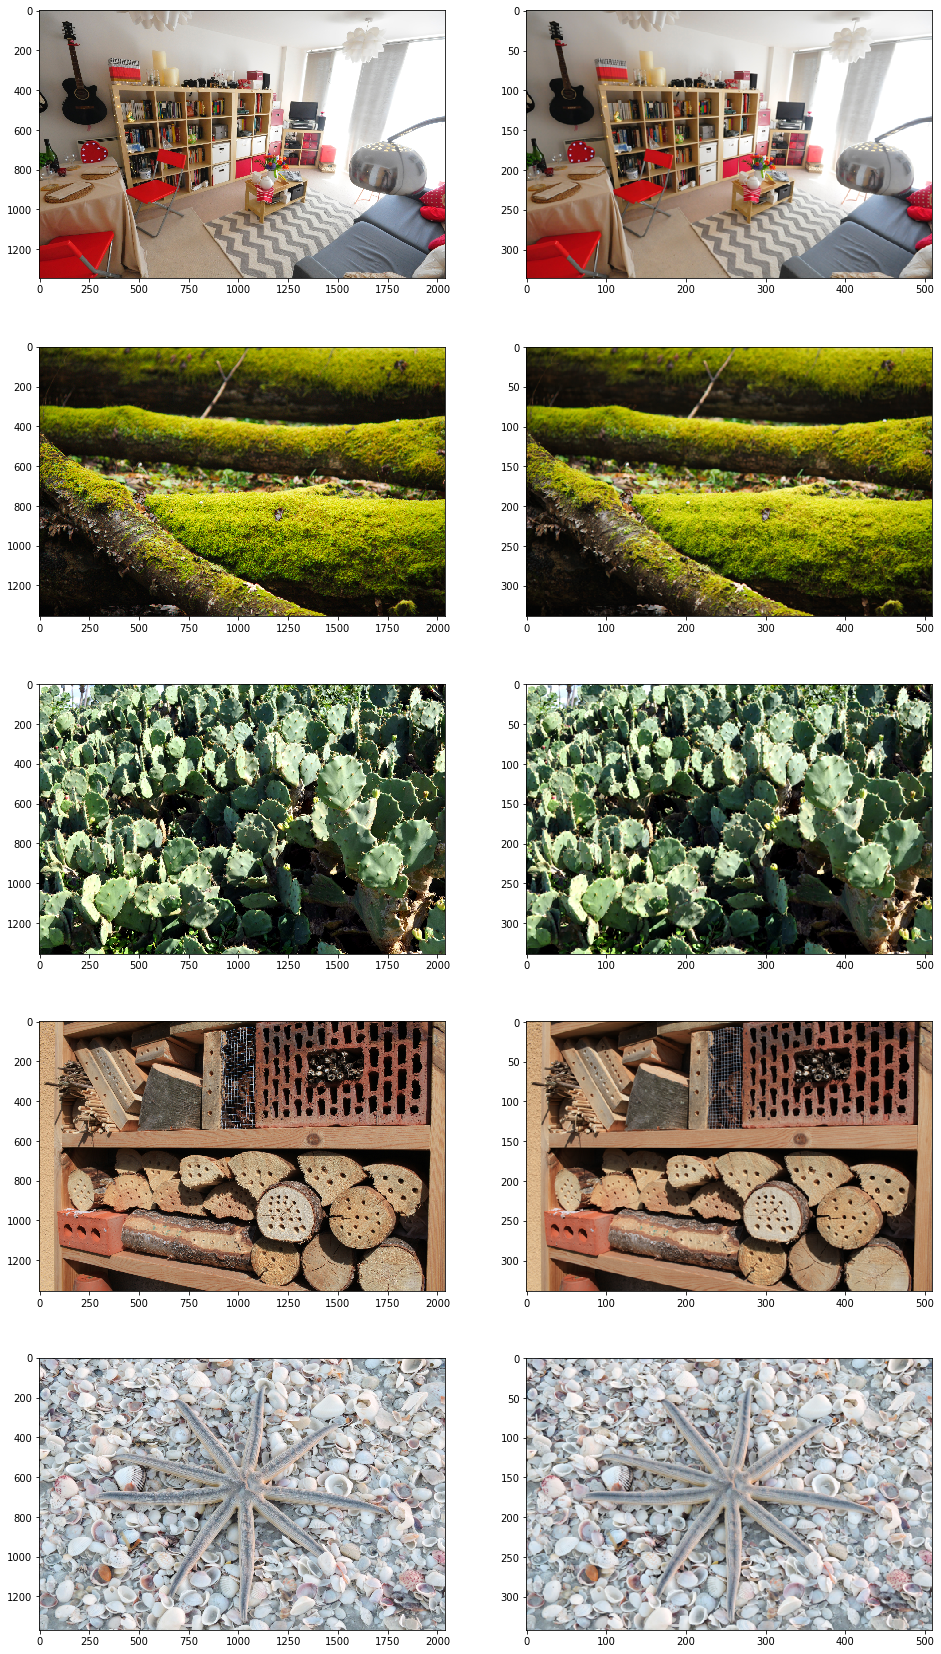

In [29]:
num_imgs_to_show = 5
start_range = 0 
end_range = start_range + num_imgs_to_show
fig, axes = plt.subplots(nrows=num_imgs_to_show,ncols=2)
fig.set_figwidth(16)
fig.set_figheight(30)
for idx,(img_hr_path, img_lr_path) in enumerate(zip(df['image_hr'].values[start_range:end_range],
                                                    df['image_lr'].values[start_range:end_range])):
    img_hr = cv2.imread(img_hr_path)
    img_hr =  cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    img_lr = cv2.imread(img_lr_path)
    img_lr =  cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    
    axes[idx][0].imshow(img_hr)
    axes[idx][1].imshow(img_lr)
plt.show()


#### Samples Images are not consistent across height and width. Resorted to padding to make them consistent across height and width.  Sample image takes up top left portion of the resultant padded image.

In [30]:
class PadUptoTargetShape(NumpyOp):
    """Preprocessing class for padding the data

    Args:
        shape: target shape of the padded image
    """
    def __init__(self, shape,inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.target_shape = shape

    def forward(self, data, state):
        """
        Args:
            data: Data to be padded
            state: A dictionary containing background information such as 'mode'

        Returns:
            Padded image, original shape
        """
        input_shape = data.shape
        required_height_padding = self.target_shape[0] - input_shape[0]
        required_weight_padding = self.target_shape[1] - input_shape[1]
        pad_sequence = [(0, required_height_padding),(0, required_weight_padding),(0,0)]
        data_padded = np.pad(data,pad_sequence,mode='constant')
        return data_padded, input_shape

#### Record writer step
ImageReader along with above mentioned padding op carried on the sample images.

In [31]:
 writer = fe.RecordWriter(
        save_dir=os.path.join(path_div2k, "tfrecords"),
        train_data=train_div2k_flickr2k_csv,
        validation_data=val_div2k_csv,
        ops=[ImageReader(inputs="image_hr", outputs="image_hr"), 
             ImageReader(inputs="image_lr", outputs="image_lr"),
             PadUptoTargetShape((510,510),inputs='image_lr',outputs=['image_lr','lr_shape']),
             PadUptoTargetShape((2040,2040),inputs='image_hr',outputs=['image_hr','hr_shape'])
             ],
        compression="GZIP",
        write_feature=['image_hr', 'hr_shape', 'image_lr', 'lr_shape'])

#### Rescale Op to keep values between 0 and 1 rather than  0 and 255. This is a pipeline operation.

In [32]:
class Rescale(TensorOp):
    """Preprocessing class for rescaling the data
    """
    def __init__(self, inputs=None, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        """
        Args:
            data: Data to be rescale
            state: A dictionary containing background information such as 'mode'

        Returns:
            Rescaled image
        """
        data = tf.cast(data, tf.float32)
        data /= 255
        return data

#### RandomImagePatches Op . The original images are captured from the padded images. From those images a patch is generated. The patch size is passed as argument. The scale is another argument, ratio between low res and high res.

In [33]:
class RandomImagePatches(TensorOp):
    """ RandomImagePatches generates crops. These crops are defined by patch_size
    """
    def __init__(self,
                 inputs=None,
                 outputs=None,
                 mode=None,
                 lr_patch_size=(48,48), scale=4):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.lr_patch_size = lr_patch_size
        self.scale = scale

    def get_image_patch(self, image_hr, image_lr, lr_shape):
        offset_height_lr = tf.random.uniform(shape=(1, ), minval=0, 
                                          maxval= lr_shape[0]- self.lr_patch_size[0]+1, dtype=tf.dtypes.int32)
        offset_width_lr = tf.random.uniform(shape=(1, ), minval=0, 
                                         maxval= lr_shape[1]- self.lr_patch_size[1]+1, dtype=tf.dtypes.int32)
        crop_img_lr = image_lr[offset_height_lr[0]:offset_height_lr[0]+ self.lr_patch_size[0], 
                               offset_width_lr[0]:offset_width_lr[0]+ self.lr_patch_size[1]]
        
        offset_height_hr = offset_height_lr[0]* self.scale
        offset_width_hr =  offset_width_lr[0]* self.scale
        hr_patch_size = (self.lr_patch_size[0]*self.scale, self.lr_patch_size[1]*self.scale)
        crop_img_hr = image_hr[offset_height_hr:offset_height_hr + hr_patch_size[0], 
                               offset_width_hr:offset_width_hr + hr_patch_size[1]]
        crop_img_hr, crop_img_lr = tf.cast(crop_img_hr, tf.float32), tf.cast(crop_img_lr, tf.float32)
        return crop_img_hr, crop_img_lr

    def forward(self, data, state):
        image_hr, hr_shape, image_lr, lr_shape = data
        image_hr = image_hr[0:hr_shape[0],0:hr_shape[1],:]
        image_lr = image_lr[0:lr_shape[0],0:lr_shape[1],:]
        crop_img_hr, crop_img_lr = self.get_image_patch(image_hr,image_lr, lr_shape)
        return crop_img_hr , crop_img_lr

#### Pipeline initialization

In [34]:
pipeline = fe.Pipeline(
    batch_size=16,
    data=writer,
    ops=[  RandomImagePatches(inputs=['image_hr','hr_shape','image_lr','lr_shape'], outputs=['image_hr','image_lr']),
         SRAugmentation2D(inputs=['image_hr','image_lr'], outputs=['image_hr', 'image_lr']), 
         Rescale(inputs='image_hr', outputs='image_hr'), Rescale(inputs='image_lr',outputs='image_hr') ])


#### Let's inspect the sample images after the pipeline stage

In [35]:
sample_batch= pipeline.show_results()

FastEstimator: Saving tfrecord to /home/ubuntu/fastestimator_data/DRLN/tfrecords
FastEstimator: Converting Train TFRecords 0.0%, Speed: 0.00 record/sec
FastEstimator: Converting Train TFRecords 5.0%, Speed: 4.88 record/sec
FastEstimator: Converting Train TFRecords 10.0%, Speed: 4.84 record/sec
FastEstimator: Converting Train TFRecords 14.9%, Speed: 4.99 record/sec
FastEstimator: Converting Train TFRecords 19.9%, Speed: 5.04 record/sec
FastEstimator: Converting Train TFRecords 24.9%, Speed: 4.62 record/sec
FastEstimator: Converting Train TFRecords 29.9%, Speed: 4.60 record/sec
FastEstimator: Converting Train TFRecords 34.9%, Speed: 5.21 record/sec
FastEstimator: Converting Train TFRecords 39.9%, Speed: 4.94 record/sec
FastEstimator: Converting Train TFRecords 44.8%, Speed: 5.16 record/sec
FastEstimator: Converting Train TFRecords 49.8%, Speed: 4.59 record/sec
FastEstimator: Converting Train TFRecords 54.8%, Speed: 5.20 record/sec
FastEstimator: Converting Train TFRecords 59.8%, Speed: 5

In [54]:
image_hr = sample_batch[0]['image_hr']
image_lr = sample_batch[0]['image_lr']

In [55]:
image_hr.shape, image_lr.shape

(TensorShape([16, 192, 192, 3]), TensorShape([16, 48, 48, 3]))

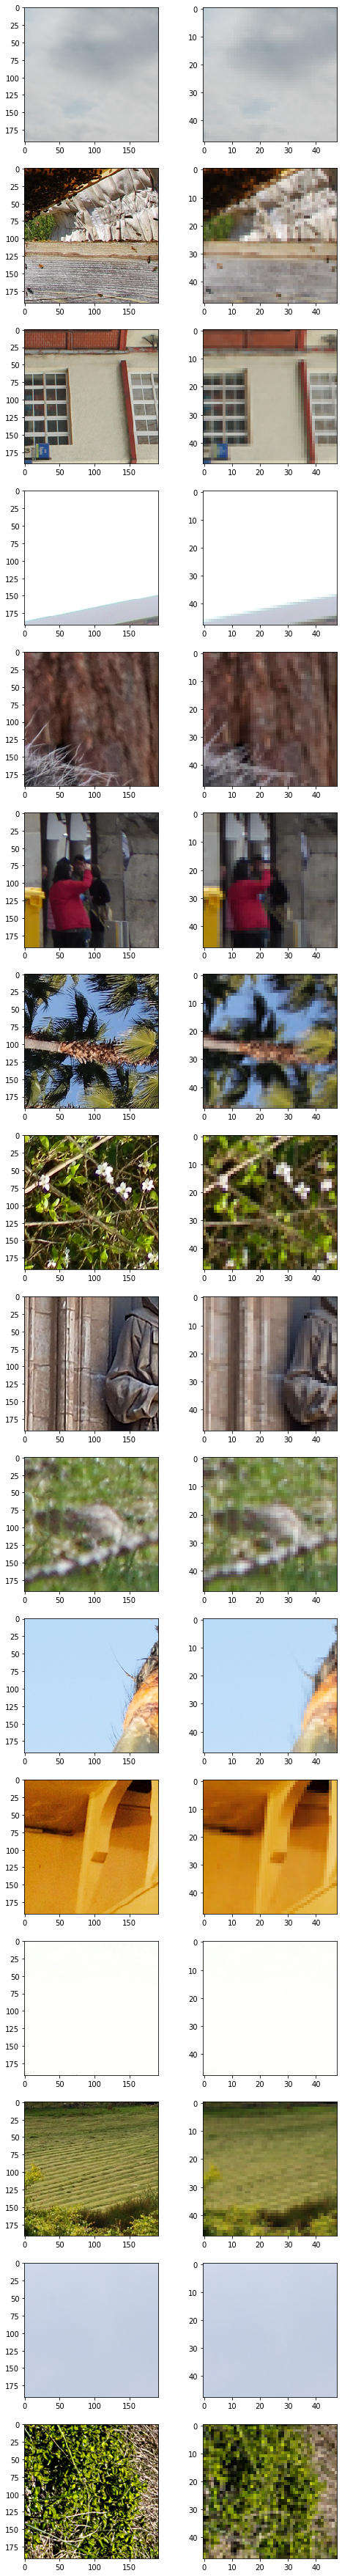

In [65]:
num_imgs_to_show = 16
fig, axes = plt.subplots(nrows=num_imgs_to_show,ncols=2)
fig.set_figwidth(8)
fig.set_figheight(64)
for idx,(img_hr, img_lr) in enumerate(zip(image_hr,image_lr)):
    axes[idx][0].imshow(img_hr.numpy()/255)
    axes[idx][1].imshow(img_lr.numpy()/255)
plt.show()

In [143]:
tf.random.uniform([],maxval=1,minval=0)

<tf.Tensor: id=66168, shape=(), dtype=float32, numpy=0.68287313>

### DRLN Network 

![title](images/drln1.png)

#### Attention Module

![title](images/drln2.png)

In [45]:
def dcr_block(layer, filters):  # densely connected residul block
    temp = layer
    layer = Conv2D(filters,3,padding='same',activation='relu')(layer)    
    layer = Conv2D(filters,3,padding='same')(layer)
    layer = Add()([layer, temp])
    layer = Activation('relu')(layer)
    return layer

def compression(layer, filters):
    layer = Conv2D(filters, 3, padding='same', activation='relu')(layer)
    return layer
    
def laplacian_attention(layer, filters, reduction):
    temp = layer
    layer = GlobalAveragePooling2D()(layer)
    layer = Reshape(target_shape=(1,1,filters))(layer)
    kernel_initializer = tf.keras.initializers.glorot_uniform()
    filter_init = kernel_initializer(shape=(3,3,filters, filters//reduction))
    c1 = tf.nn.conv2d(layer,filters=filter_init, strides=1, padding=[[0, 0], [3,3], [3,3], [0, 0]], dilations=3)
    c2 = tf.nn.conv2d(layer, filters=filter_init, strides=1, padding=[[0, 0], [5,5], [5,5], [0, 0]], dilations=5)
    c3 = tf.nn.conv2d(layer, filters=filter_init, strides=1, padding=[[0, 0], [7,7], [7,7], [0, 0]], dilations=7)
    c_out =  concatenate([c1,c2,c3], axis=-1)
    out =  Conv2D(filters,3,padding='same',activation='sigmoid')(c_out)
    return temp * out

def upsample_block(layer, filters, scale):
    for _ in range(int(np.math.log(scale,2))):
        layer = Conv2D(filters*4,3,padding='same')(layer)
        layer = SubPixelConv2D(upsample_factor=2, nchannels=filters)(layer)
    return layer
    
def drl_module(layer, filters=64):
    
    reduction = 16

    temp = layer 
    layer = dcr_block(layer, filters)
    layer = concatenate([layer, temp], axis=-1)
    
    temp = layer 
    layer = dcr_block(layer, 2*filters)
    layer = concatenate([layer, temp], axis=-1)
    
    temp = layer 
    layer = dcr_block(layer, 4*filters)
    layer = concatenate([layer, temp], axis=-1)
    
    layer = compression(layer, filters)
    layer = laplacian_attention(layer, filters, reduction)
    return layer
    
def drl_network(input_shape=(32,32,3)):
    inputs = Input(input_shape)
    filters = 64
    
    bias_neg = tf.constant_initializer(np.array([-0.46116419, -0.44462357, -0.40349178]))
    bias_pos = tf.constant_initializer(np.array([0.46116419, 0.44462357, 0.40349178]))
    kernel_init = tf.constant_initializer(np.array([[[[1.,0.,0.],[0.,0.,1.],[0.,0.,1.]]]]))
    meanshifted_inputs= Conv2D(3,1, bias_initializer=bias_neg, kernel_initializer=kernel_init, trainable=False)(inputs)
    
    head = Conv2D(filters,3,padding='same')(meanshifted_inputs)
    x = head
    #===============================================================
    
    drlm_out = drl_module(head)    #1
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)

    drlm_out = drl_module(x)          # 2
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)          # 3
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a1 = head + x 
    
    #============================================================
    
    drlm_out = drl_module(a1)           # 4
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)           # 5
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)           # 6
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a2 = a1 + x
    
    #===================================================================
    
    drlm_out = drl_module(a2)           # 7
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)           # 8
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)            # 9
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a3 = a2 + x
    
    #===========================================================================
    
    drlm_out = drl_module(a3)            # 10
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)              # 11
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                # 12
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a4 = a3 + x
    
    #=================================================================
    
    drlm_out = drl_module(a4)                  # 13
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                      # 14
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                    # 15
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    
    drlm_out = drl_module(x)                       # 16
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a5 = a4 + x
    
    #=========================================================================
    
    
    
    drlm_out = drl_module(a5)                         # 17
    drlm_concat = concatenate([x, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                          # 18
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                           # 19
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    drlm_out = drl_module(x)                           # 20
    drlm_concat = concatenate([temp, drlm_out], axis=3)
    temp = drlm_concat
    x = Conv2D(filters,3,padding='same')(drlm_concat)
    
    a6 = a5 + x
    
    #=============================================================================
    
    out = a6 + head
    up_out = upsample_block(out, filters,scale=4)
    final_out = Conv2D(3,3,padding='same')(up_out)
    #  reverse operation of mean shift
    final_out= Conv2D(3,1, bias_initializer=bias_pos, kernel_initializer=kernel_init, trainable=False)(final_out)
    return Model(inputs=inputs, outputs=final_out)

#### Mean Average loss is chosen as the error. Note it is not mean square error.

In [ ]:
class ContentLoss(Loss):
    """Compute generator loss."""
    def __init__(self, inputs, outputs=None, mode=None):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.mae_loss =  tf.keras.losses.MeanAbsoluteError(reduction='none')

    def forward(self, data, state):
        superres, highres = data
        batch_size, _, _, _ = superres.shape
        superres = tf.reshape(superres, (batch_size, -1))
        highres = tf.reshape(highres, (batch_size, -1))
        mae_loss = self.mae_loss(highres, superres)
        return mae_loss

#### LR is selected as 1e-4 , subsequently reduced by 2 every 200000 iterations.

In [40]:
class MyLRSchedule(LRSchedule):
    """ lrschedule to modify lr for drln.  """
    def schedule_fn(self, current_step_or_epoch, lr):
        divisor = np.power(2,current_step_or_epoch//200000)
        lr = lr/divisor
        return lr

#### Model and Network 

In [68]:
 model_drln = fe.build(model_def= lambda: drl_network(input_shape=(48,48,3)),
                          model_name="drln",
                          optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                          loss_name="mae_loss")


In [69]:
network = fe.Network(ops=[
        ModelOp(inputs='image_lr', model=model_drln, outputs='image_sr'),
        ContentLoss(inputs=("image_sr", "image_hr"), outputs=("mae_loss")),
    ])

#### Estimator

In [70]:
model_dir = os.path.join(path_div2k)
estimator = fe.Estimator(
    network=network,
    pipeline=pipeline,
    steps_per_epoch=215,
    epochs=1390,
    traces=[
        ModelSaver(model_name="drln", save_dir=model_dir, save_best=True),
        LRController(model_name="drln", lr_schedule=MyLRSchedule(schedule_mode='step'))
    ])

#### Training begins ...

In [35]:
estimator.fit()

#### Inference

In [71]:
model_drln.load_weights(os.path.join(path_drln, 'drln_best_mae_loss.h5' ))

In [80]:
sample_batch = pipeline.show_results(mode='eval')

FastEstimator: Reading non-empty directory: /home/ubuntu/fastestimator_data/DRLN/tfrecords
FastEstimator: Found 3450 examples for train in /home/ubuntu/fastestimator_data/DRLN/tfrecords/train_summary0.json
FastEstimator: Found 100 examples for eval in /home/ubuntu/fastestimator_data/DRLN/tfrecords/eval_summary0.json


In [81]:
image_sr_validation = model_drln(sample_batch[0]['image_lr'])

In [83]:
image_hr_numpy = sample_batch[0]['image_hr'].numpy()
image_lr_numpy = sample_batch[0]['image_lr'].numpy()
image_sr_numpy = image_sr_validation.numpy()
print(image_sr_numpy.shape)

(16, 192, 192, 3)


In [46]:
# fig, axes = plt.subplots(nrows=16, ncols=3)
# fig.set_figwidth(12)
# fig.set_figheight(64)
# for i in range(16):
#     axes[i][0].imshow(image_lr_numpy[i]/255)
#     axes[i][1].imshow(image_hr_numpy[i]/255)
#     axes[i][2].imshow(image_sr_numpy[i]/255)
# plt.show()